In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
import datetime as dt
from datetime import datetime
from shapely.geometry import Point
import metloom
from metloom.pointdata import CDECPointData
from metloom.variables import CdecStationVariables
import pickle

<Axes: >

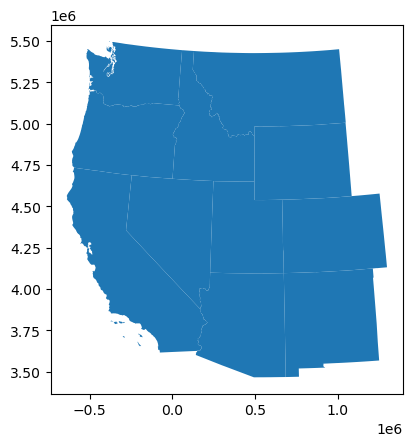

In [2]:
wstates = gpd.read_file('../data/misc/western_states.shp')

wstates_4326=wstates.to_crs('epsg:4326')

wstates_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

wstates.plot()

## Access CDEC:

In [3]:
pkl_fn = '../data/cdec/cdec_locations.pkl'

if os.path.exists(pkl_fn):
    cdec_locations = pickle.load(open(pkl_fn, 'rb'))
else:
    vrs = [
        #CdecStationVariables.SWE,
        CdecStationVariables.SNOWDEPTH
    ]
    points = CDECPointData.points_from_geometry(wstates_boundary.to_crs('epsg:4326'), vrs, 
                                                snow_courses=False)
    cdec_locations = points.to_dataframe()
    cdec_locations.set_crs('epsg:4326')    
    cdec_locations.to_pickle(pkl_fn)

cdec_locations.head()

,name,id,datasource,geometry
0,GREYHORSE 2 NODE 7,G07,CDEC,POINT Z (-120.35160 39.13071 6200.00000)
1,GREYHORSE 2 NODE 1,G01,CDEC,POINT Z (-120.34932 39.12893 6200.00000)
2,COTTONWOOD NODE 8,CT8,CDEC,POINT Z (-120.38163 39.10828 6200.00000)
3,COTTONWOOD NODE 6,CT6,CDEC,POINT Z (-120.38199 39.10760 6200.00000)
4,COTTONWOOD NODE 4,CT4,CDEC,POINT Z (-120.38247 39.10751 6200.00000)


In [10]:
# cdec_ids = []

# for i in range(len(cdec_locations)):
#     cdec_ids.append(cdec_locations.id.values[i])

NameError: name 'western_snotel' is not defined

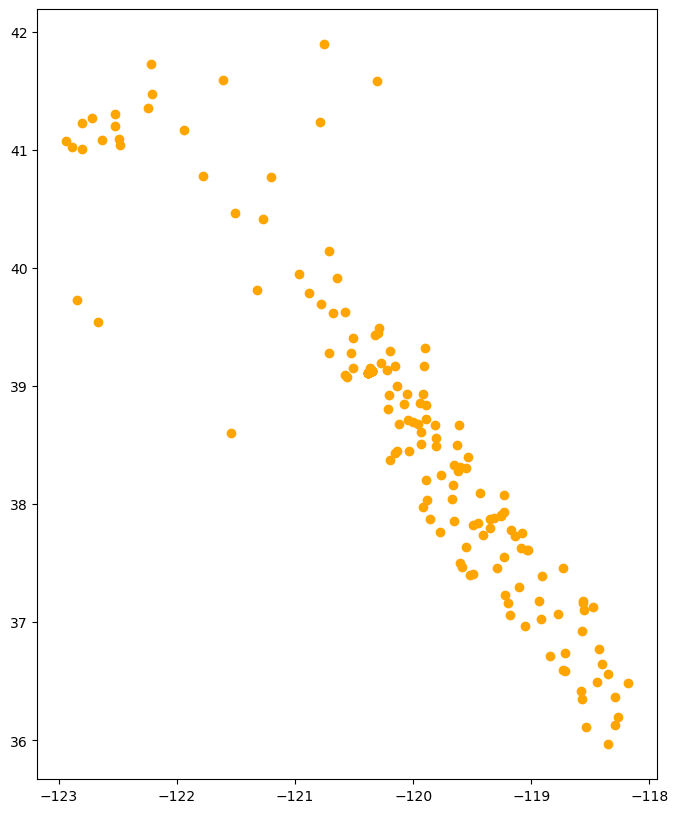

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

cdec_locations.plot(ax=ax, facecolor='orange')
western_snotel.to_crs('epsg:4326').plot(facecolor='green', ax=ax, alpha=.5)
wstates.loc[wstates['NAME']=='California'].to_crs('epsg:4326').plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_xlim(-121,-119)
ax.set_ylim(37,41)

Concatenating snow depth dataframes:
* Make an empty dataframe with index datetime from one of the cdec dataframes
* download snow depth data for a station
* reindex from multiindex to datetime index
* Add SNOWDEPTH colum as the site name horizontally to the new dataframe making sure the datetime index matches up
* Iterate over all stations

In [4]:
# Download data for Dan to get the datetime index:
pkl_fn = '../data/cdec/cdec_swe.pkl'

if os.path.exists(pkl_fn):
    cdec_swe = pickle.load(open(pkl_fn, 'rb'))
else:
    cdec_point = CDECPointData("DAN", "DAN")
    dan_swe_multiindex = cdec_point.get_daily_data(
        datetime(1990,3,1), datetime(2023,4,2),
        [cdec_point.ALLOWED_VARIABLES.SWE])
    # Reindex from a multiindex so I can use the datetime index:
    dan_swe_resetindex = dan_swe_multiindex.reset_index()
    dan_swe = dan_swe_resetindex.set_index('datetime')

In [19]:
dan_swe.index.year.unique()

Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int32', name='datetime')

In [5]:
pkl_fn = '../data/cdec/cdec_swe.pkl'

if os.path.exists(pkl_fn):
    cdec_swe = pickle.load(open(pkl_fn, 'rb'))
else:
    # Create a new empty dataframe with the TUM datetime index:
    cdec_swe = pd.DataFrame()
    cdec_swe.index = pd.DatetimeIndex(data=dan_swe.index)
    
    # Iteratively download all the data and add the SWE column to the snwd_df:
    for i in range(len(cdec_locations)):
        cdec_point = CDECPointData(cdec_locations.id.values[i], cdec_locations.id.values[i])
        point_swe = cdec_point.get_daily_data(
            datetime(1990,3,1), datetime(2023,4,2),
            [cdec_point.ALLOWED_VARIABLES.SWE]
        )
        if point_swe is not None:
            point_swe = point_swe.reset_index()
            point_swe = point_swe.set_index('datetime')
            point_swe = point_swe.drop(columns={'site','geometry','SWE_units','datasource'})
            point_swe = point_swe.rename(columns={'SWE':f'{cdec_locations.id.values[i]}'})
            cdec_swe = pd.concat((cdec_swe, point_swe), axis=1)
            #cdec_swe[f'{cdec_locations.id.values[i]}'] = point_swe['SWE']
                
        else:
            continue
    cdec_swe.to_pickle(pkl_fn)

In [6]:
cdec_swe_april1 = cdec_swe.loc[cdec_swe.index.month == 4] 
cdec_swe_april1 = cdec_swe_april1.loc[cdec_swe_april1.index.day == 1]
cdec_swe_april1_nan = cdec_swe_april1.dropna(axis=1)

In [23]:
cdec_swe_april1.head(2)

,SWM,PLP,MUM,GKS,DPK,MED,GNL,HIG,PET,SNM,...,MDW,BLA,TES,MAM,RP2,HRS,STL,SDW,FDC,MNT
datetime,,,,,,,,,,,,,,,,,,,,,
1990-04-01 08:00:00+00:00,11.04,8.76,1.80,NaN,NaN,16.08,23.04,2.52,10.44,5.72,...,NaN,3.36,NaN,29.8,13.6,28.0,13.2,NaN,NaN,NaN
1991-04-01 08:00:00+00:00,15.00,23.40,12.12,NaN,NaN,16.80,29.33,18.26,13.92,19.09,...,NaN,11.16,NaN,27.7,21.4,26.6,22.5,NaN,NaN,12.5


In [25]:
cdec_swe_april1_nan.head()

,PLP,UBC,CRL,CSV,CAP,HHM,BLD
datetime,,,,,,,
1990-04-01 08:00:00+00:00,8.76,19.61,12.60,11.11,15.72,28.32,17.52
1991-04-01 08:00:00+00:00,23.40,29.41,18.84,18.95,17.64,22.68,25.00
1992-04-01 08:00:00+00:00,15.60,27.45,15.96,13.72,14.40,31.20,18.51
1993-04-01 08:00:00+00:00,28.44,58.83,35.29,28.77,40.93,66.72,47.63
1994-04-01 08:00:00+00:00,14.64,23.54,17.75,10.47,14.05,7.55,18.71


In [7]:
# Remove CDEC site locations that were eliminated from cdec_depth in the nan removal step
cdec_nan_locations = cdec_locations.copy()

index_list = []
for x in cdec_swe_april1_nan.columns:
    index_list.append(x)
    
x_list = []
for x in cdec_nan_locations.id:
    x_list.append(x)

drop_list = []
for i in x_list:
    if i not in index_list:
        drop_list.append(cdec_nan_locations.index.get_loc(np.where(cdec_nan_locations['id']==i)[0][0]))

for i in drop_list:
    cdec_nan_locations = cdec_nan_locations.drop([i])

In [15]:
cdec_nan_locations

,name,id,datasource,geometry
48,DANA MEADOWS,DAN,CDEC,POINT Z (-119.25726 37.89616 9800.00000)
50,HORSE MEADOW (NRCS),HOR,CDEC,POINT Z (-119.88730 38.83650 8557.00000)
85,INDEPENDENCE CREEK,INN,CDEC,POINT Z (-120.29300 39.49400 6500.00000)
115,TRUCKEE 2,TK2,CDEC,POINT Z (-120.19400 39.30000 6400.00000)
117,MARLETTE LAKE,MRL,CDEC,POINT Z (-119.90500 39.17300 8000.00000)
123,ROCK CREEK LAKES,RCK,CDEC,POINT Z (-118.73502 37.45728 9700.00000)
148,BLUE LAKES,BLK,CDEC,POINT Z (-119.93100 38.61300 8000.00000)
150,INDEPENDENCE CAMP,IDC,CDEC,POINT Z (-120.29855 39.45259 7000.00000)
168,SUMMIT MEADOW,SDW,CDEC,POINT Z (-119.53560 38.39750 9313.00000)


(37.0, 41.0)

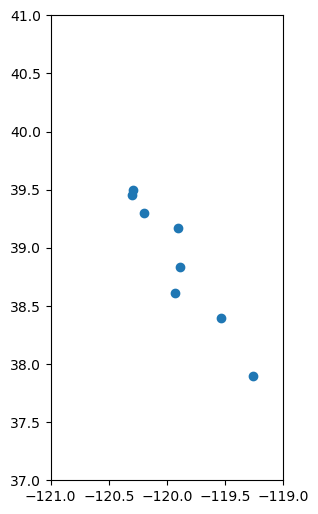

In [22]:
fig, ax = plt.subplots(figsize=(3,10))

#western_snotel.plot(ax=ax)
cdec_nan_locations.plot(ax=ax)
ax.set_xlim(-121,-119)
ax.set_ylim(37,41)

In [9]:
cdec_april1_anom = cdec_swe_april1_nan - np.nanmean(cdec_swe_april1_nan, axis=0)

In [36]:
cdec_april1_anom.index.hour

Index([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype='int32', name='datetime')

In [11]:
# changing hour from 8 to 0 to match snotel index
index_list = []
for i in range(len(cdec_april1_anom.index)):
    x = cdec_april1_anom.index[i].replace(hour=0)
    index_list.append(x)
cdec_april1_anom.index = index_list

index_list = []
for i in range(len(cdec_swe_april1_nan.index)):
    x = cdec_swe_april1_nan.index[i].replace(hour=0)
    index_list.append(x)
cdec_swe_april1_nan.index = index_list

In [49]:
cdec_april1_anom.head()

,PLP,UBC,CRL,CSV,CAP,HHM,BLD
1990-04-01 00:00:00+00:00,-23.545882,-13.977941,-11.080294,-5.921176,-11.886176,-9.999706,-11.364118
1991-04-01 00:00:00+00:00,-8.905882,-4.177941,-4.840294,1.918824,-9.966176,-15.639706,-3.884118
1992-04-01 00:00:00+00:00,-16.705882,-6.137941,-7.720294,-3.311176,-13.206176,-7.119706,-10.374118
1993-04-01 00:00:00+00:00,-3.865882,25.242059,11.609706,11.738824,13.323824,28.400294,18.745882
1994-04-01 00:00:00+00:00,-17.665882,-10.047941,-5.930294,-6.561176,-13.556176,-30.769706,-10.174118


In [50]:
cdec_nan_locations

,name,id,datasource,geometry
9,PILOT PEAK (DWR),PLP,CDEC,POINT Z (-120.87778 39.78589 6800.00000)
57,UPPER BURNT CORRAL,UBC,CDEC,POINT Z (-118.93829 37.18330 9700.00000)
99,CHARLOTTE LAKE,CRL,CDEC,POINT Z (-118.42601 36.77752 10400.00000)
107,CASA VIEJA MEADOWS,CSV,CDEC,POINT Z (-118.26769 36.19810 8300.00000)
118,CAPLES LAKE,CAP,CDEC,POINT Z (-120.04158 38.71079 8000.00000)
124,HIGHLAND MEADOW,HHM,CDEC,POINT Z (-119.80563 38.49066 8700.00000)
146,BLOODS CREEK,BLD,CDEC,POINT Z (-120.03488 38.45126 7200.00000)


In [12]:
cdec_april1_anom.to_pickle('../data/cdec/cdec_april1_swe_anom.pkl')
cdec_swe_april1_nan.to_pickle('../data/cdec/cdec_april1_swe.pkl')
cdec_nan_locations.to_pickle('../data/cdec/cdec_nan_swe_locations.pkl')